<center> Bruno Luvizotto Carli </center>
<p style="text-align:center;"> Universidade Federal do Paraná </p>
<p style="text-align:right;"> 2021 </p>

<br />
<hr />
<br />

<h3> Introdução </h3>

<p style="text-align:justify;">
O presente artigo pretende investigar os resultados da aplicação de técnicas depré-processamento de dados sob uma base de dados de fonte pública. O tema escolhido foi Infecções confirmadas por Covid-19 no Município de Curitiba.A prefeitura disponibiliza uma base de dados Oliveira (2021),de casos confirmados da doença, de onde se pretende extrair os dados, identificar uma variável preditora, aplicar um modelo de machine learning e identificar os resultados de melhoria que as técnicas de escalonamento e padronização dos dados na fase de pré-processamento podem propiciar ao modelo.
</p>

<br />

<h3> Trabalhos relacionados </h3>

<p style="text-align:justify;">
    Rizatti <i>et al</i>. (2020) realizaram um mapeamento da pandemia em Santa Maria/RS ao qual apresentou ideias enaltecedoras na resolução da visualização do nível de infecção nas zonas urbanas da cidade, motivação suficiente para buscar a geolocalização dos distritos utilizados na base de dados deste trabalho a fim de promover uma ilustração semelhante par aa cidade de Curitiba.
</p>

<p style="text-align:justify;">
Porém a essência da proposta deste trabalho somente pode se desenrolar sob a luz iluminadora de Guizelini et al. (2020) cujo foi a maçã de newton para este estudo, possibilitando revelar a variável preditora escondida como agulha no palheiro dos dados escolhidos para o estudo. Guizelini et al. (2020) do Laboratório de Inteligência Artificial Aplicada a Bioinformática (AIBIA) da Universidade Federal do Paraná (UFPR) utilizaram algoritmos para prever as <b>médias móveis</b> de casos de infecção por Covid no territorio nacional. Estes, justificam a usabilidade dos dados escolhidos, cujos apresentaram grande resiliência à análise, cabendo ao pesquisador desbobrar os dados para a extração da informação que será utilizada como combustível dos algoritmos de machine learning e consequentemente, ilustrar a porposta deste trabalho: avaliar a influência da padronização e escalonamento dos dados sob o resultado da previsão do modelo.
</p>


### Bibliotecas utilizadas

In [332]:
from collections import Counter
import folium
from folium import plugins
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import plot_confusion_matrix

### Metodologia

<p style="text-align:justify;">
Conforme Harrison (2020) "O CRISP-DM (Cross-Industry Standard Process for Data Mining ou processo para fazer mineração de dados (data mining), o qual contém vários passos que podem ser seguidos para uma melhoria contínua" elencando-os:
</p>

- Entendimento do negócio;
- Entendimento dos dados;
- Preparação dos dados;
- Modelagem;
- Avaliação;
- Implantação.

<p style="text-align:justify;">
Para fins deste estudo vamos apenas focar nas fases de entendimento e preparação dos dados, modelagem e avaliação do modelo. Após a limpeza inicial será calculado com base nas datas de ocorrência as médias móveis para número de infectados e para o número de óbitos. A partir desta informação utilizarse-a de modelos de regrassão para estimar os valores futuros para infectados e óbitos. Salienta-se aqui que o objetivo do estudo em si, não é prever com eficiência e precisão os dados futuros, mas sim observar o impacto do pré-processamento, comparado os resultados das regressões sob modelos treinados nos dados brutos e modelos trinados sob dados escalonados e padronizados.
</p>

### Base de dados

<p style="text-align:justify;">
    A base de dados utilizada foi a <b>Casos de COVID-19 em Curitiba</b> Oliveira (2021), cuja possui 234125 instâncias para 7 colunas de características, das quais descreve-se a data de notificação, idade, gênero, região sanitária (bairro), data de óbito (se em caso de óbito) e estado do indivíduo (se recuperado ou óbito). Todos as ocorrências são casos em que a doença foi confirmada.
</p>

<br />

In [333]:
# this works on my mac
df = pd.read_csv('2021-06-24_Casos_Covid_19_-_Base_de_Dados.csv', sep=';')
df.columns = ['notification_date', 'class', 'age',
              'gender', 'district', 'death_date', 'status', '_']
df.drop(columns='_', inplace=True)

# This works on my linux
# df = pd.read_csv('2021-07-01_Casos_Covid_19_-_Base_de_Dados.csv', sep=',', encoding='UTF-8')
# df.columns = ['notification_date', 'class', 'age',
#               'gender', 'district', 'death_date', 'status']

# lol

# shows table
df.head()

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,notification_date,class,age,gender,district,death_date,status
0,11/03/2020,CONFIRMADO,54,M,DSMZ,NaN,RECUPERADO
1,12/03/2020,CONFIRMADO,43,M,DSBQ,NaN,RECUPERADO
2,12/03/2020,CONFIRMADO,15,M,DSBQ,NaN,RECUPERADO
3,12/03/2020,CONFIRMADO,25,F,DSMZ,NaN,RECUPERADO
4,12/03/2020,CONFIRMADO,58,M,DSMZ,NaN,RECUPERADO


<small><center> Tabela 1: Dados brutos. Fonte: Oliveira (2021) </center></small>

### Limpando os dados

<p style="text-align:justify;">
O atributo `class`, cujo descreve se a notificação corresponde à um caso confirmado de covid, apresenta o mesmo valor para todas as instâncias, logo, esta é uma característica desnecessária podendo ser descartada.
</p>

In [334]:
print("Unique values in every column \n"+'-'*25)
for i in df.columns:
    print("\t"+i+" = ",len(set(df[i])))

Unique values in every column 
-------------------------
	notification_date =  467
	class =  1
	age =  762
	gender =  6
	district =  11
	death_date =  417
	status =  3


In [335]:
df.drop(columns=['class'], inplace=True)

<p style="text-align:justify;">
A base de dados apresenta tipagem irregular, cabendo uma limpeza inicial dos dados, pode-se verificar a irregularidade ao analizar incial da base de dados, revelando que todos os dados são do tipo `object`:
</p>

In [336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234125 entries, 0 to 234124
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   notification_date  234125 non-null  object
 1   age                234123 non-null  object
 2   gender             234125 non-null  object
 3   district           221052 non-null  object
 4   death_date         5984 non-null    object
 5   status             226193 non-null  object
dtypes: object(6)
memory usage: 10.7+ MB


<p style="text-align:justify;">
Ao verificar por linhas que contém valores ausentes, determinou-se que a coluna idade apresenta duas linhas à qual não contém a informação, portanto pode-se remover estas linhas. As colunas `district` e `status` apresenta muitos dados para que seja removido, podendo impactar nos resultados. A coluna `death_date` e `status` apresentam ausencia devido a binaridade da informação, pois as ocorrências que não apresentam data de óbito, consequentemente, não foram a óbito, portanto optou-se por manter estes registros, removendo apenas as instâncias com dados ausentes para idade.
</p>

In [337]:
df.isnull().sum()

notification_date         0
age                       2
gender                    0
district              13073
death_date           228141
status                 7932
dtype: int64

In [338]:
# drop null age rows
df.dropna(subset = ["age"], inplace=True)
print(df.isnull().sum())

notification_date         0
age                       0
gender                    0
district              13073
death_date           228139
status                 7932
dtype: int64


In [339]:
districts = []
for district in df.district.values:
    if district is np.nan:
        districts.append('UNKNOWN')
    else:
        districts.append(district)
df['district'] = districts

Para os dados de idade, foi necessário realizar um casting para inteiro.

In [340]:
# all ages to int
ages = []
for i in df.age.values:
    try:
        age = int(i)
    except ValueError as e:
        age = int(float(str(i).replace(',', '.')))
    except Exception as e:
        print(e)
        age = i
    ages.append(age)
df['age'] = ages

Os gêneros cujos estavam definidos como atributos categóricos (`M` e `F`) foram substituidos por valores binários, sendo `1` para masculino e `0` para feminino.

In [341]:
# all genders to binary
def gender_2bin(char):
    return 1 if char.lower() == 'm' else 0

genders = [gender_2bin(char) for char in df.gender.values]
df['gender'] = genders

O mesmo foi realizado para o *status* final do infectado, onde substituiu-se o `status` por variáveis *dummy* representando se o indivíduo se recuperou ou se foi a óbito.

In [342]:
df[['recovered', 'dead']] = pd.get_dummies(df['status'])
df.drop(columns=['status'], inplace=True)
df

,notification_date,age,gender,district,death_date,recovered,dead
0,11/03/2020,54,1,DSMZ,NaN,1,0
1,12/03/2020,43,1,DSBQ,NaN,1,0
2,12/03/2020,15,1,DSBQ,NaN,1,0
3,12/03/2020,25,0,DSMZ,NaN,1,0
4,12/03/2020,58,1,DSMZ,NaN,1,0
...,...,...,...,...,...,...,...
234120,19/06/2021,63,0,DSBQ,NaN,0,0
234121,19/06/2021,67,0,DSMZ,NaN,0,0
234122,19/06/2021,55,0,UNKNOWN,NaN,0,0
234123,21/06/2021,58,1,DSCJ,21/06/2021,0,1


Uma análise inicial revela que de `234125`, `5984` foram a óbito e `228139` recuperaram-se da doença, ou ainda, pode-se dizer que **2.5%** das incidências resultaram em óbito para **97.4%** de indivíduos que recuperaram-se da infecção.

In [343]:
print('Number of deaths: ', len([i for i in df.dead if i == 1]))
print('Number of recovered: ', len([i for i in df.dead if i == 0]))

Number of deaths:  5984
Number of recovered:  228139


/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='dead', ylabel='count'>

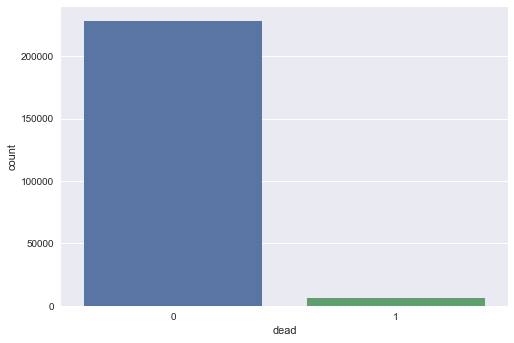

In [344]:
sns.countplot(df['dead'])

Optou-se por particionar a data em colunas específicas para expandir a análise exploratória:

In [345]:
try:
    df['notification_date'] = pd.to_datetime(df['notification_date'])
    df['notification_year'] = df['notification_date'].dt.year
    df['notification_month'] = df.notification_date.dt.month
    df['notification_day'] = df.notification_date.dt.day
except:
    pass

try:
    df['death_date'] = pd.to_datetime(df['death_date'])
    df['death_year'] = df['death_date'].dt.year
    df['death_month'] = df.death_date.dt.month
except:
    pass

try:
    df['death_date'] = pd.to_datetime(df['death_date'])
    df['death_year'] = df['death_date'].dt.year
    df['death_month'] = df.death_date.dt.month
except:
    pass


df.head()

,notification_date,age,gender,district,death_date,recovered,dead,notification_year,notification_month,notification_day,death_year,death_month
0,2020-11-03,54,1,DSMZ,NaT,1,0,2020,11,3,NaN,NaN
1,2020-12-03,43,1,DSBQ,NaT,1,0,2020,12,3,NaN,NaN
2,2020-12-03,15,1,DSBQ,NaT,1,0,2020,12,3,NaN,NaN
3,2020-12-03,25,0,DSMZ,NaT,1,0,2020,12,3,NaN,NaN
4,2020-12-03,58,1,DSMZ,NaT,1,0,2020,12,3,NaN,NaN


Para um melhor entendimento e visualização dos distritos afetados, buscou-se traduzir as siglas que compõem o nome da região Curitiba (2021) assim como coletar os valores de geolocalização (latitude e longitude) das regiões para uma apresentação visual das ocorrências por distrito:

In [346]:
# tradução das siglas identificadas em:
# https://www.curitiba.pr.gov.br/servicos/enderecos-da-vigilancia-sanitaria-municipal/729
district_map = {
    'DSMZ': 'Matriz',
    'DSBQ': 'Boqueirão',
    'DSPR': 'Portão',
    'DSBV': 'Boa Vista',
    'DSSF': 'Santa Felicidade',
    'DSCJ': 'Cajuru',
    'DSPN': 'Pinheirinho',
    'DSCIC': 'CIC',
    'DSBN': 'Bairro Novo',
    'DSTQ': 'Tatuquara'
}

districts_geomap = {
    'DSMZ': (-25.4307842, -49.3039002),
    'DSBQ': (-25.5054148, -49.2529249),
    'DSPR': (-25.4720321, -49.3185196),
    'DSBV': (-25.3863067, -49.2645271),
    'DSSF': (-25.3953506, -49.364192),
    'DSCJ': (-25.4613033, -49.2268961),
    'DSPN': (-25.5238141, -49.3104457),
    'DSCIC': (-25.4945581, -49.4133876),
    'DSBN': (-25.5710449, -49.3092243),
    'DSTQ': (-25.5606956, -49.33638)
}

district_areas_km = {
    'DSBN': 4479,
    'DSTQ': 1122,
    'DSMZ': 3628,
    'DSBQ': 3985,
    'DSPR': 3346,
    'DSBV': 6222,
    'DSSF': 6529,
    'DSCJ': 3530,
    'DSPN': 5676,
    'DSCIC': 5817,
}

In [347]:
lats, longs = [], []
for value in df.district.values:
    if value in districts_geomap:
        lt, lg = districts_geomap.get(value)
        lats.append(lt)
        longs.append(lg)
    else:
        lats.append(np.nan)
        longs.append(np.nan)

assert len(lats) == len(longs) == len(df.district)
df['latitude'] = lats
df['longitude'] = longs

In [348]:
df['district'].value_counts()

DSBV       33620
DSCIC      26463
DSBQ       23942
DSCJ       23690
DSPN       21367
DSPR       21237
DSBN       20044
DSMZ       18458
DSSF       17879
DSTQ       14350
UNKNOWN    13073
Name: district, dtype: int64

In [349]:
district_counts = []
district_count_map =  Counter(df['district'].values)
for district in df.district.values:
    if district in district_count_map:
        district_counts.append(district_count_map.get(district))
    else:
        district_counts.append(df.district.isnull().sum())

assert len(district_counts) == len(df)
df['region_ocurrences'] = district_counts

In [350]:
m = folium.Map(location=districts_geomap['DSMZ'], zoom_start=11.4)

for k, v in districts_geomap.items():
    folium.Marker(v, popup=district_map.get(k)).add_to(m)
    folium.Circle(
        radius=district_areas_km.get(k)/2,
        location=v,
        popup=district_count_map.get(k),
        color="crimson",
        fill=True,
        opacity=district_count_map.get(k)*.00001,
        fill_opacity=(district_count_map.get(k)/100)*.001 + .52
    ).add_to(m)

m

<p style="text-align:justify;">
Ao observar a média de ocorrência por idade, observa-se que a tendência está entre os 25 e 50 anos de idade:
</p>

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


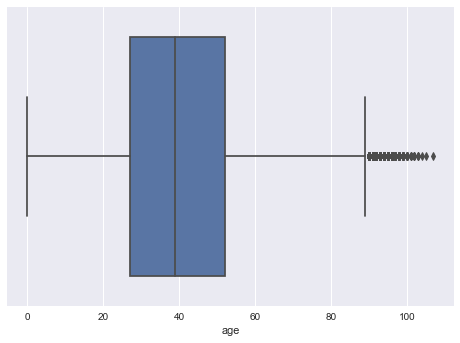

In [351]:
sns.boxplot(df['age'])
plt.show()

<AxesSubplot:ylabel='Frequency'>

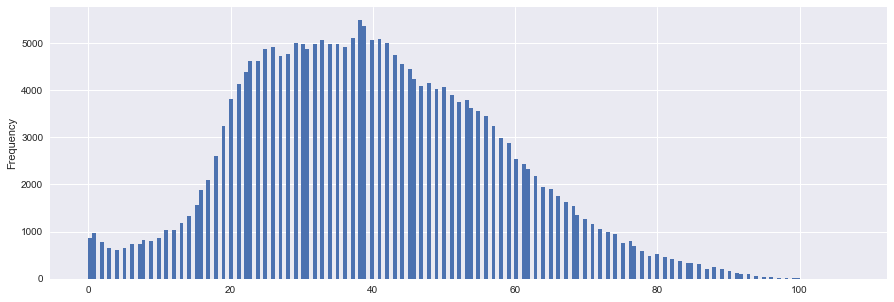

In [352]:
df.age.plot.hist(figsize=(15, 5), bins=200)

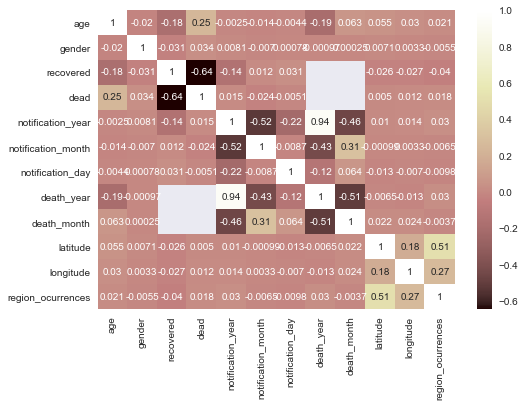

In [353]:
sns.heatmap(df.corr(), annot=True, cmap='pink')
plt.show()

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='notification_year', ylabel='count'>

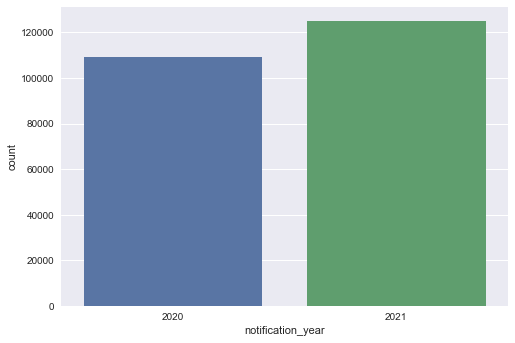

In [354]:
sns.countplot(df['notification_year'])

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='death_month', ylabel='count'>

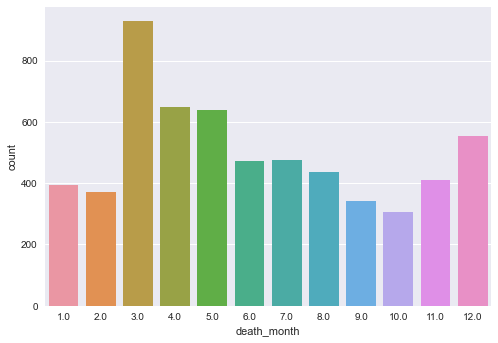

In [355]:
sns.countplot(df['death_month'])

/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gender', ylabel='count'>

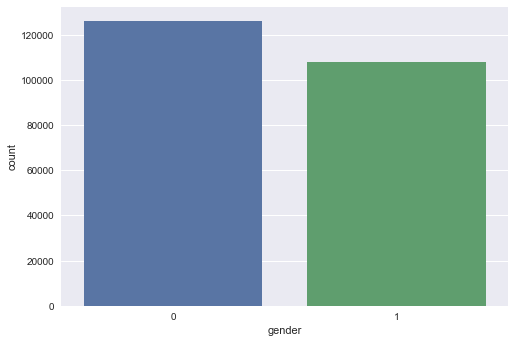

In [356]:
sns.countplot(df['gender'])

array([[<AxesSubplot:title={'center':'notification_date'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'death_date'}>],
       [<AxesSubplot:title={'center':'recovered'}>,
        <AxesSubplot:title={'center':'dead'}>,
        <AxesSubplot:title={'center':'notification_year'}>,
        <AxesSubplot:title={'center':'notification_month'}>],
       [<AxesSubplot:title={'center':'notification_day'}>,
        <AxesSubplot:title={'center':'death_year'}>,
        <AxesSubplot:title={'center':'death_month'}>,
        <AxesSubplot:title={'center':'latitude'}>],
       [<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'region_ocurrences'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

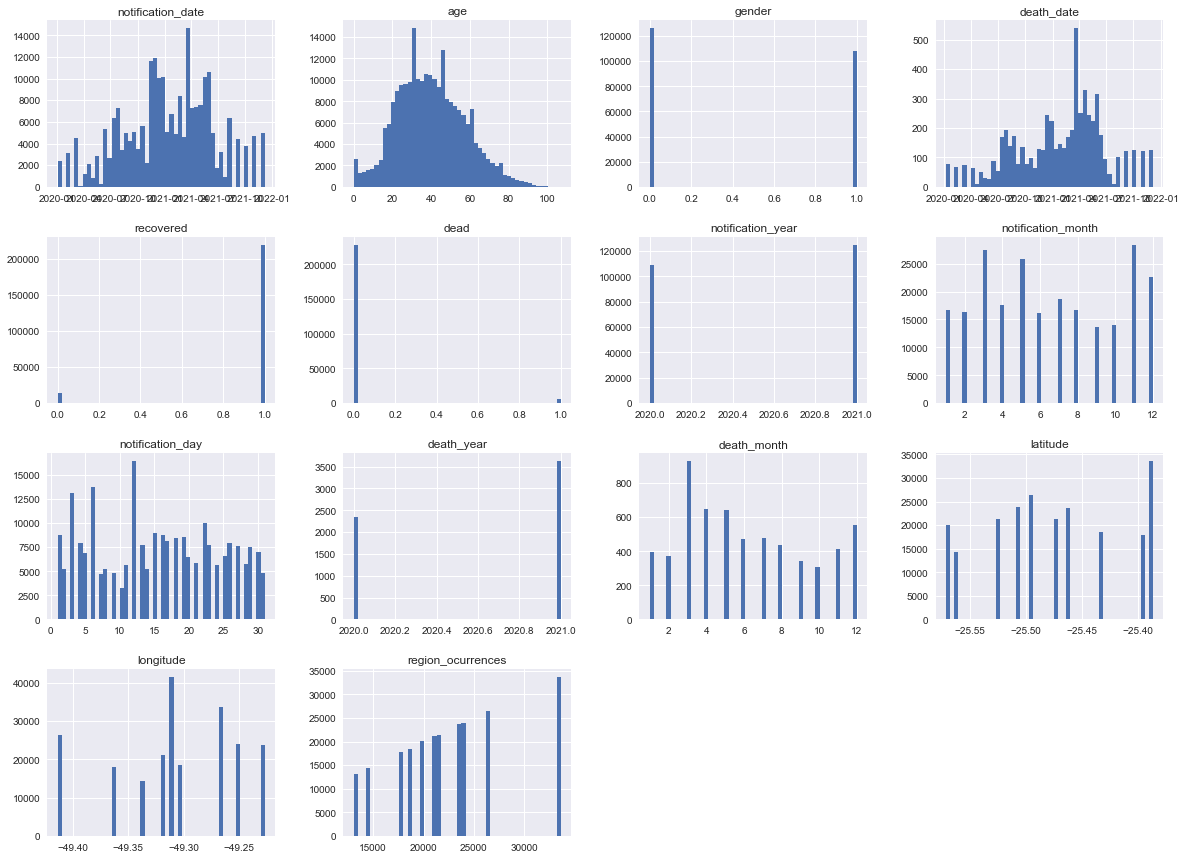

In [357]:
df.hist(bins=50, figsize=(20, 15))

In [358]:
parsed_df = df[['notification_year', 'notification_month', 'notification_day', 'recovered', 'dead']].copy()
dead_grouped_by_date = {}
infected_grouped_by_date = {}

for data_point in parsed_df.values:
    year, month, day = data_point[0], data_point[1], data_point[2]
    recovered, dead = data_point[3], data_point[4]
    key = f'{day}/{month}/{year}'

    if key in dead_grouped_by_date.keys():
        dead_grouped_by_date[key] += dead
    else:
        dead_grouped_by_date[key] = dead

    if key in infected_grouped_by_date.keys():
        infected_grouped_by_date[key] += 1
    else:
        infected_grouped_by_date[key] = 1


In [359]:
dead_count_avg = pd.DataFrame(dead_grouped_by_date.items(), columns=['date', 'count'])
dead_count_avg['date'] = pd.to_datetime(dead_count_avg.date)
dead_count_avg = dead_count_avg.sort_values(by="date")

infected_count_avg = pd.DataFrame(infected_grouped_by_date.items(), columns=['date', 'count'])
infected_count_avg['date'] = pd.to_datetime(infected_count_avg.date)
infected_count_avg = infected_count_avg.sort_values(by="date")

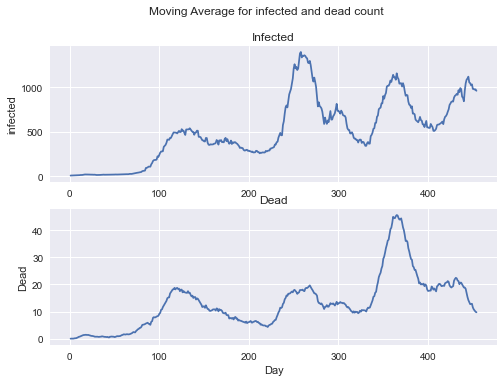

In [360]:
gap = 14
infected_results = []
count = 0
while count < len(infected_count_avg) - gap + 1:
    group = infected_count_avg['count'].values[count : count + gap]
    group_avg = sum(group) / gap
    infected_results.append(group_avg)
    count +=1

infected_day_month = []
for day in range(1, len(infected_results) + 1):
    infected_day_month.append(day)


dead_results = []
count = 0
while count < len(dead_count_avg) - gap + 1:
    group = dead_count_avg['count'].values[count : count + gap]
    group_avg = sum(group) / gap
    dead_results.append(group_avg)

    count +=1

dead_day_month = []
for day in range(1, len(dead_results) + 1):
    dead_day_month.append(day)

plt.style.use('seaborn')
fig, axs = plt.subplots(2)
fig.suptitle('Moving Average for infected and dead count')
axs[0].set_title('Infected')
axs[1].set_title('Dead')

    
# Visualizar gráfico de médias móveis
axs[0].set(ylabel='infected')
axs[0].plot(infected_day_month, infected_results)

# Visualizar gráfico de médias móveis
axs[1].set(xlabel='Day', ylabel='Dead')
axs[1].plot(dead_day_month, dead_results)
plt.show()

Gráfico 1: Médias móveis para infectados e óbitos

In [361]:
infected_df = pd.DataFrame({'date': infected_day_month, 'avg': infected_results})
dead_df = pd.DataFrame({'date': dead_day_month, 'avg': dead_results})

In [362]:
infected_df.tail()

,date,avg
449,450,982.142857
450,451,980.214286
451,452,973.857143
452,453,977.000000
453,454,960.928571


In [363]:
dead_df.tail()

,date,avg
449,450,11.500000
450,451,10.785714
451,452,10.357143
452,453,9.928571
453,454,9.714286


#### Particionando os dados

<p style="text-align:justify;">
De acordo com Jain (2021) é tradicionalmente comum entre cientistas de dados, dividir aleatoriamente o conjunto de dados, testar e aplicar uma validação cruzada. Mas ao invés disso pode-se utilizar uma outra bordagem chamada <b>time-base splitting</b> (JAIN, 2021) onde aplica-se um recorte temporal no conjunto. Esta aboragem cabe perfeitamente ao problema proposto.
<p style="text-align:justify;">

<AxesSubplot:title={'center':'Infected'}>

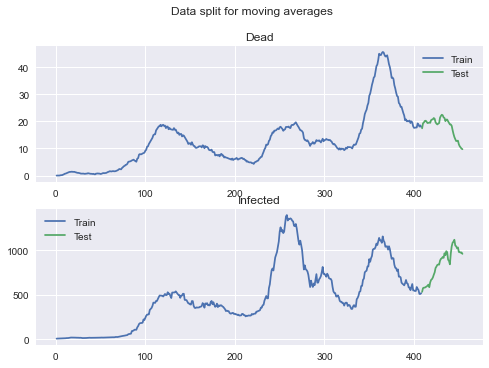

In [364]:
fig, axs = plt.subplots(2)
fig.suptitle('Data split for moving averages')
axs[0].set_title('Dead')
axs[1].set_title('Infected')
             
X = dead_df['date'].values
y = dead_df['avg'].values

train_length = int(len(dead_df)*0.9)
test_length = len(dead_df) - train_length

dead_X_train = X[0:train_length]
dead_y_train = y[0:train_length]

dead_X_test = X[train_length:len(dead_df)]
dead_y_test = y[train_length:len(dead_df)]

sns.lineplot(x=dead_X_train, y=dead_y_train, label='Train', ax=axs[0])
sns.lineplot(x=dead_X_test, y=dead_y_test, label='Test', ax=axs[0])


X = infected_df['date'].values
y = infected_df['avg'].values

train_length = int(len(infected_df)*0.9)
test_length = len(infected_df) - train_length

infected_X_train = X[0:train_length]
infected_y_train = y[0:train_length]

infected_X_test = X[train_length:len(infected_df)]
infected_y_test = y[train_length:len(infected_df)]

sns.lineplot(x=infected_X_train, y=infected_y_train, label='Train', ax=axs[1])
sns.lineplot(x=infected_X_test, y=infected_y_test, label='Test', ax=axs[1])

Grafico 2: Divisão de treino e teste

### Treinando os modelos iniciais

<p style="text-align:justify;">
Foram treinados quatro modelos de regressão básicos sob os dados particionados para infectados e registros de óbito, como pode-se ver no Gráfico 3 e 4 a Floresta Aleatório apresenta sobreajuste sobre os dados de treino de contagemd e infectados, tendendo a linearidade no teste, de mesmo modo, a Perceptron Multi Camada também tende a linearidade após convergir. O modelo mais flexível nos testes iniciais é a SVR. Nas contagems de óbito os modelos apresentam as mesmas características
</p>


<AxesSubplot:>

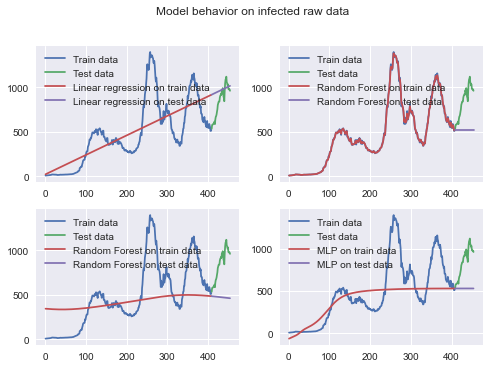

In [365]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Model behavior on infected raw data')


# Linear regression
lin_reg = LinearRegression()
lin_reg.fit(infected_X_train.reshape(-1, 1), infected_y_train)

predictions = lin_reg.predict(infected_X_test.reshape(-1, 1))
lin_mse = mean_squared_error(infected_y_test, predictions)
lin_rmse = np.sqrt(lin_mse)

# Random forest
forest_reg = RandomForestRegressor()
forest_reg.fit(infected_X_train.reshape(-1, 1), infected_y_train)
forest_predictions = forest_reg.predict(infected_X_test.reshape(-1, 1))

forest_mse = mean_squared_error(infected_y_test, forest_predictions)
forest_rmse = np.sqrt(forest_mse)

# SVR
svr = SVR()
svr.fit(infected_X_train.reshape(-1, 1), infected_y_train)
svr_preds = svr.predict(infected_X_test.reshape(-1, 1))
svr_mse = mean_squared_error(infected_y_test, svr_preds)
svr_rmse = np.sqrt(svr_mse)

# MLP
mlp = MLPRegressor(
    activation='logistic',
    learning_rate_init=0.01,
    random_state=1, max_iter=500).fit(infected_X_train.reshape(-1, 1), infected_y_train)
mlp_preds = mlp.predict(infected_X_test.reshape(-1, 1))
mlp_mse = mean_squared_error(infected_y_test, mlp_preds)
mlp_rmse = np.sqrt(mlp_mse)


# Plots
sns.lineplot(x=infected_X_train, y=infected_y_train, label='Train data', ax=axs[0,0])
sns.lineplot(x=infected_X_test, y=infected_y_test, label='Test data', ax=axs[0,0])
sns.lineplot(x=infected_X_train, y=lin_reg.predict(infected_X_train.reshape(-1, 1)), label='Linear regression on train data', ax=axs[0,0])
sns.lineplot(x=infected_X_test, y=predictions, label='Linear regression on test data', ax=axs[0,0])

sns.lineplot(x=infected_X_train, y=infected_y_train, label='Train data', ax=axs[0,1])
sns.lineplot(x=infected_X_test, y=infected_y_test, label='Test data', ax=axs[0,1])
sns.lineplot(x=infected_X_train, y=forest_reg.predict(infected_X_train.reshape(-1, 1)), label='Random Forest on train data', ax=axs[0,1])
sns.lineplot(x=infected_X_test, y=forest_predictions, label='Random Forest on test data', ax=axs[0,1])

sns.lineplot(x=infected_X_train, y=infected_y_train, label='Train data', ax=axs[1,0])
sns.lineplot(x=infected_X_test, y=infected_y_test, label='Test data', ax=axs[1,0])
sns.lineplot(x=infected_X_train, y=svr.predict(infected_X_train.reshape(-1, 1)), label='Random Forest on train data', ax=axs[1,0])
sns.lineplot(x=infected_X_test, y=svr_preds, label='Random Forest on test data', ax=axs[1,0])

sns.lineplot(x=infected_X_train, y=infected_y_train, label='Train data', ax=axs[1,1])
sns.lineplot(x=infected_X_test, y=infected_y_test, label='Test data', ax=axs[1,1])
sns.lineplot(x=infected_X_train, y=mlp.predict(infected_X_train.reshape(-1, 1)), label='MLP on train data', ax=axs[1,1])
sns.lineplot(x=infected_X_test, y=mlp_preds, label='MLP on test data', ax=axs[1,1])


Gráfico 3: Modelos de regressão iniciais n contagem de infectados

In [366]:
print('###'*9)
print('Linear regression Scores')
print('---'*9)
print('Score: ', lin_reg.score(infected_X_test.reshape(-1, 1), infected_y_test))
print('R-2: ', metrics.r2_score(infected_y_test, predictions))
print('Absolute Error: ', metrics.mean_absolute_error(infected_y_test, predictions))
print('RMSE: ', lin_rmse)

print('###'*9)
print('Random forest Scores')
print('---'*9)
print('Score: ', forest_reg.score(infected_X_test.reshape(-1, 1), infected_y_test))
print('R-2: ', metrics.r2_score(infected_y_test, forest_predictions))
print('Absolute Error: ',metrics.mean_absolute_error(infected_y_test, forest_predictions))
print('RMSE: ', forest_rmse)

print('###'*9)
print('SVR')
print('---'*9)
print('Score: ', svr.score(infected_X_test.reshape(-1, 1), infected_y_test))
print('R-2: ', metrics.r2_score(infected_y_test, svr_preds))
print('Absolute Error: ', metrics.mean_absolute_error(infected_y_test, svr_preds))
print('RMSE: ', svr_rmse)

print('###'*9)
print('MLP')
print('---'*9)
print('Score: ', mlp.score(infected_X_test.reshape(-1, 1), infected_y_test))
print('R-2: ', metrics.r2_score(infected_y_test, mlp_preds))
print('Absolute Error: ', metrics.mean_absolute_error(infected_y_test, mlp_preds))
print('RMSE: ', mlp_rmse)
print('---'*9)

###########################
Linear regression Scores
---------------------------
Score:  -0.21150242399063868
R-2:  -0.21150242399063868
Absolute Error:  143.9849593717681
RMSE:  188.4213687022088
###########################
Random forest Scores
---------------------------
Score:  -3.68090030308605
R-2:  -3.68090030308605
Absolute Error:  328.4316770186343
RMSE:  370.3673602422749
###########################
SVR
---------------------------
Score:  -4.837550041860695
R-2:  -4.837550041860695
Absolute Error:  373.6303546022264
RMSE:  413.602655807464
###########################
MLP
---------------------------
Score:  -3.432939695270499
R-2:  -3.432939695270499
Absolute Error:  317.20504955065593
RMSE:  360.4241825542098
---------------------------


<AxesSubplot:>

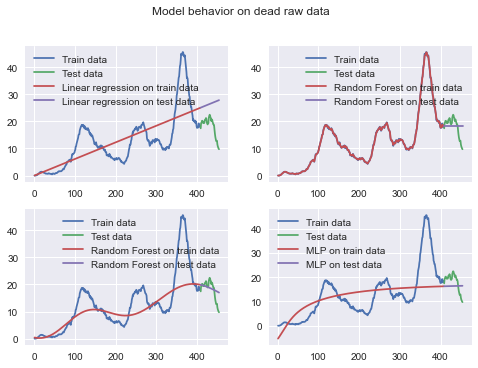

In [367]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Model behavior on dead raw data')


# Linear regression
lin_reg = LinearRegression()
lin_reg.fit(dead_X_train.reshape(-1, 1), dead_y_train)

predictions = lin_reg.predict(dead_X_test.reshape(-1, 1))
lin_mse = mean_squared_error(dead_y_test, predictions)
lin_rmse = np.sqrt(lin_mse)

# Random forest
forest_reg = RandomForestRegressor()
forest_reg.fit(dead_X_train.reshape(-1, 1), dead_y_train)
forest_predictions = forest_reg.predict(dead_X_test.reshape(-1, 1))

forest_mse = mean_squared_error(dead_y_test, predictions)
forest_rmse = np.sqrt(forest_mse)

# SVR
svr = SVR()
svr.fit(dead_X_train.reshape(-1, 1), dead_y_train)
svr_preds = svr.predict(dead_X_test.reshape(-1, 1))
svr_mse = mean_squared_error(dead_y_test, svr_preds)
svr_rmse = np.sqrt(svr_mse)

# MLP
mlp = MLPRegressor(
    activation='logistic',
    learning_rate_init=0.01,
    random_state=1, max_iter=500).fit(dead_X_train.reshape(-1, 1), dead_y_train)
mlp_preds = mlp.predict(dead_X_test.reshape(-1, 1))
mlp_mse = mean_squared_error(dead_y_test, mlp_preds)
mlp_rmse = np.sqrt(mlp_mse)


# Plots
sns.lineplot(x=dead_X_train, y=dead_y_train, label='Train data', ax=axs[0,0])
sns.lineplot(x=dead_X_test, y=dead_y_test, label='Test data', ax=axs[0,0])
sns.lineplot(x=dead_X_train, y=lin_reg.predict(dead_X_train.reshape(-1, 1)), label='Linear regression on train data', ax=axs[0,0])
sns.lineplot(x=dead_X_test, y=predictions, label='Linear regression on test data', ax=axs[0,0])

sns.lineplot(x=dead_X_train, y=dead_y_train, label='Train data', ax=axs[0,1])
sns.lineplot(x=dead_X_test, y=dead_y_test, label='Test data', ax=axs[0,1])
sns.lineplot(x=dead_X_train, y=forest_reg.predict(dead_X_train.reshape(-1, 1)), label='Random Forest on train data', ax=axs[0,1])
sns.lineplot(x=dead_X_test, y=forest_predictions, label='Random Forest on test data', ax=axs[0,1])

sns.lineplot(x=dead_X_train, y=dead_y_train, label='Train data', ax=axs[1,0])
sns.lineplot(x=dead_X_test, y=dead_y_test, label='Test data', ax=axs[1,0])
sns.lineplot(x=dead_X_train, y=svr.predict(dead_X_train.reshape(-1, 1)), label='Random Forest on train data', ax=axs[1,0])
sns.lineplot(x=dead_X_test, y=svr_preds, label='Random Forest on test data', ax=axs[1,0])

sns.lineplot(x=dead_X_train, y=dead_y_train, label='Train data', ax=axs[1,1])
sns.lineplot(x=dead_X_test, y=dead_y_test, label='Test data', ax=axs[1,1])
sns.lineplot(x=dead_X_train, y=mlp.predict(dead_X_train.reshape(-1, 1)), label='MLP on train data', ax=axs[1,1])
sns.lineplot(x=dead_X_test, y=mlp_preds, label='MLP on test data', ax=axs[1,1])


Gráfico 4: Modelos de regressão iniciais n contagem de infectados

In [368]:
print('###'*9)
print('Linear regression Scores')
print('---'*9)
print('Score: ', lin_reg.score(dead_X_test.reshape(-1, 1), dead_y_test))
print('R-2: ', metrics.r2_score(dead_y_test, predictions))
print('Absolute Error: ', metrics.mean_absolute_error(dead_y_test, predictions))
print('RMSE: ', lin_rmse)

print('###'*9)
print('Random forest Scores')
print('---'*9)
print('Score: ', forest_reg.score(dead_X_test.reshape(-1, 1), dead_y_test))
print('R-2: ', metrics.r2_score(dead_y_test, forest_predictions))
print('Absolute Error: ', metrics.mean_absolute_error(dead_y_test, forest_predictions))
print('RMSE: ', forest_rmse)

print('###'*9)
print('SVR')
print('---'*9)
print('Score: ', svr.score(dead_X_test.reshape(-1, 1), dead_y_test))
print('R-2: ', metrics.r2_score(dead_y_test, svr_preds))
print('Absolute Error: ', metrics.mean_absolute_error(dead_y_test, svr_preds))
print('RMSE: ', svr_rmse)

print('###'*9)
print('MLP')
print('---'*9)
print('Score: ', mlp.score(dead_X_test.reshape(-1, 1), dead_y_test))
print('R-2: ', metrics.r2_score(dead_y_test, mlp_preds))
print('Absolute Error: ', metrics.mean_absolute_error(dead_y_test, mlp_preds))
print('RMSE: ', mlp_rmse)
print('---'*9)

###########################
Linear regression Scores
---------------------------
Score:  -5.7220824999680335
R-2:  -5.7220824999680335
Absolute Error:  8.335664365129668
RMSE:  9.341966354078588
###########################
Random forest Scores
---------------------------
Score:  -0.0003427551992400968
R-2:  -0.0003427551992400968
Absolute Error:  2.900310559006216
RMSE:  9.341966354078588
###########################
SVR
---------------------------
Score:  0.28827542725947886
R-2:  0.28827542725947886
Absolute Error:  2.219401221775762
RMSE:  3.039781446074649
###########################
MLP
---------------------------
Score:  -0.2576304475353668
R-2:  -0.2576304475353668
Absolute Error:  3.7911295711505693
RMSE:  4.040758556802266
---------------------------


### Escalonando os dados

<p style="text-align:justify;">
De acordo com Géron (2019, p.68) "Uma das transformações mais importantes que você precisa aplicar aos seus dados é o <i>escalonamento das características</i>. Com poucas exceções, os algoritmos de Aprendixado de Máquina não funcionam bem quando atributos numéricos de entrada tem escalas muito diferentes" portanto será aplicado um pipeline cujo transformará os dados aplicando um <i>imputer</i> e em seguida um Escalonador Padrão (<i>StandardScaler</i>).
<p style="text-align:justify;">
    

<br />

#### imputer:

O imputer calcula a média de cada atributo

<br />

#### Escalonador Padrão

O escalonamento padrão subtrai o valor médio e divide pela variância:

<br />

\begin{equation}
    z = \frac{(x - avg)}{std}
\end{equation}

<br />


In [369]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())
])
# infectados
transformed_infected_X_train = num_pipeline.fit_transform(infected_X_train.reshape(-1, 1))
transformed_infected_X_test = num_pipeline.fit_transform(infected_X_test.reshape(-1, 1))

transformed_infected_y_train = num_pipeline.fit_transform(infected_y_train.reshape(-1, 1))
transformed_infected_y_test = num_pipeline.fit_transform(infected_y_test.reshape(-1, 1))

# Óbitos
transformed_dead_X_train = num_pipeline.fit_transform(dead_X_train.reshape(-1, 1))
transformed_dead_X_test = num_pipeline.fit_transform(dead_X_test.reshape(-1, 1))

transformed_dead_y_train = num_pipeline.fit_transform(dead_y_train.reshape(-1, 1))
transformed_dead_y_test = num_pipeline.fit_transform(dead_y_test.reshape(-1, 1))

## Ajustando os parâmetros dos modelos

In [288]:
%%capture

# Linear regression
param_grid = [{'n_jobs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]}]
infected_lin_grid_search = GridSearchCV(lin_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
infected_lin_grid_search.fit(transformed_infected_X_train, transformed_infected_y_train)
dead_lin_grid_search = GridSearchCV(lin_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
dead_lin_grid_search.fit(transformed_dead_X_train, transformed_dead_y_train)

# RandomForest
param_grid = [
    {
        'n_estimators': [10, 50, 100, 200, 500],
        'max_depth': [1, 2, 3, 4, 5],
    },
]
infected_forest_grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
infected_forest_grid_search.fit(transformed_infected_X_train, transformed_infected_y_train)
dead_forest_grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
dead_forest_grid_search.fit(transformed_dead_X_train, transformed_dead_y_train)


# SVR
param_grid = [
    {
        'C': [2.0, 2.1, 2.2, 2.5, 2.7, 3.0, 4.0, 5.0, 50],
        'degree': [-1, 1, 1.5, 2, 3, 4, 5],
        'epsilon': [0.1, 0.2, 0.3, 0.5, 0.7]
    },
]

infected_svr_grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
infected_svr_grid_search.fit(transformed_infected_X_train, transformed_infected_y_train)
dead_svr_grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
dead_svr_grid_search.fit(transformed_dead_X_train, transformed_dead_y_train)


# MLP
param_grid = [
    {
        'learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 0.9],
        'max_iter': [200, 500, 800],
        'hidden_layer_sizes': [(100, ), (256, 128), (512, 256, 128), (1000, 500, 300)]
    },
]

infected_mlp_grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error')
infected_mlp_grid_search.fit(transformed_infected_X_train, transformed_infected_y_train)
dead_mlp_grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error')
dead_mlp_grid_search.fit(transformed_dead_X_train, transformed_dead_y_train)

In [370]:
print('Linear Regression')
print('Infected: ', infected_lin_grid_search.best_params_)
print('Dead: ', dead_lin_grid_search.best_params_)
print('---'*9)
print('Random Forest')
print('Infected: ', infected_forest_grid_search.best_params_)
print('Dead: ', dead_forest_grid_search.best_params_)
print('---'*9)
print('SVR')
print('Infected: ', infected_svr_grid_search.best_params_)
print('Dead: ', dead_svr_grid_search.best_params_)
print('---'*9)
print('MLP')
print('Infected: ', infected_mlp_grid_search.best_params_)
print('Dead: ', dead_mlp_grid_search.best_params_)
print('---'*9)

Linear Regression
Infected:  {'n_jobs': 1}
Dead:  {'n_jobs': 1}
---------------------------
Random Forest
Infected:  {'max_depth': 2, 'n_estimators': 100}
Dead:  {'max_depth': 4, 'n_estimators': 500}
---------------------------
SVR
Infected:  {'C': 50, 'degree': 1, 'epsilon': 0.5}
Dead:  {'C': 50, 'degree': 1, 'epsilon': 0.3}
---------------------------
MLP
Infected:  {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.1, 'max_iter': 800}
Dead:  {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'max_iter': 200}
---------------------------


### Retreinando os modelos

<ipython-input-371-15a53ba2ee74>:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_reg.fit(transformed_infected_X_train, transformed_infected_y_train)
/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<AxesSubplot:>

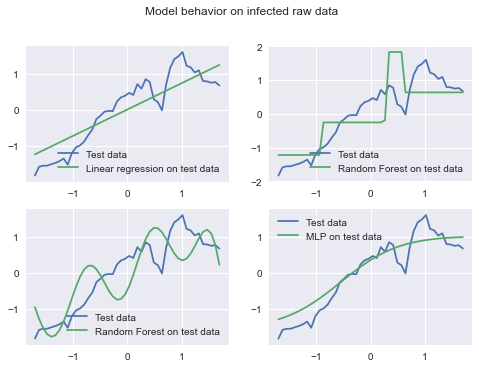

In [371]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Model behavior on infected raw data')


# Linear regression
lin_reg = LinearRegression(n_jobs=1)
lin_reg.fit(transformed_infected_X_train, transformed_infected_y_train)

predictions = lin_reg.predict(transformed_infected_X_test)
lin_mse = mean_squared_error(transformed_infected_y_test, predictions)
lin_rmse = np.sqrt(lin_mse)

# Random forest
forest_reg = RandomForestRegressor(max_depth=2, n_estimators=100)
forest_reg.fit(transformed_infected_X_train, transformed_infected_y_train)
forest_predictions = forest_reg.predict(transformed_infected_X_test)

forest_mse = mean_squared_error(transformed_infected_y_test, forest_predictions)
forest_rmse = np.sqrt(forest_mse)

# SVR
svr = SVR(C=50, degree=1, epsilon=0.5)
svr.fit(transformed_infected_X_train, transformed_infected_y_train)
svr_preds = svr.predict(transformed_infected_X_test)
svr_mse = mean_squared_error(transformed_infected_y_test, svr_preds)
svr_rmse = np.sqrt(svr_mse)

# MLP
mlp = MLPRegressor(
    activation='logistic',
    learning_rate_init=0.1,
    random_state=1, max_iter=800).fit(transformed_infected_X_train, transformed_infected_y_train)
mlp_preds = mlp.predict(transformed_infected_X_test)
mlp_mse = mean_squared_error(transformed_infected_y_test, mlp_preds)
mlp_rmse = np.sqrt(mlp_mse)


# Plots
# sns.lineplot(x=transformed_infected_X_train.reshape(-1), y=transformed_infected_y_train.reshape(-1), label='Train data', ax=axs[0,0])
sns.lineplot(x=transformed_infected_X_test.reshape(-1), y=transformed_infected_y_test.reshape(-1), label='Test data', ax=axs[0,0])
# sns.lineplot(x=transformed_infected_X_train.reshape(-1), y=lin_reg.predict(transformed_infected_X_train).reshape(-1), label='Linear regression on train data', ax=axs[0,0])
sns.lineplot(x=transformed_infected_X_test.reshape(-1), y=lin_reg.predict(transformed_infected_X_test).reshape(-1), label='Linear regression on test data', ax=axs[0,0])


# sns.lineplot(x=transformed_infected_X_train.reshape(-1), y=transformed_infected_y_train.reshape(-1), label='Train data', ax=axs[0,1])
sns.lineplot(x=transformed_infected_X_test.reshape(-1), y=transformed_infected_y_test.reshape(-1), label='Test data', ax=axs[0,1])
# sns.lineplot(x=transformed_infected_X_train.reshape(-1), y=forest_reg.predict(transformed_infected_X_train).reshape(-1), label='Random Forest on train data', ax=axs[0,1])
sns.lineplot(x=transformed_infected_X_test.reshape(-1), y=forest_predictions.reshape(-1), label='Random Forest on test data', ax=axs[0,1])

# sns.lineplot(x=transformed_infected_X_train.reshape(-1), y=transformed_infected_y_train.reshape(-1), label='Train data', ax=axs[1,0])
sns.lineplot(x=transformed_infected_X_test.reshape(-1), y=transformed_infected_y_test.reshape(-1), label='Test data', ax=axs[1,0])
# sns.lineplot(x=transformed_infected_X_train, y=svr.predict(transformed_infected_X_train), label='Random Forest on train data', ax=axs[1,0])
sns.lineplot(x=transformed_infected_X_test.reshape(-1), y=svr_preds.reshape(-1), label='Random Forest on test data', ax=axs[1,0])

# sns.lineplot(x=transformed_infected_X_train, y=transformed_infected_y_train, label='Train data', ax=axs[1,1])
sns.lineplot(x=transformed_infected_X_test.reshape(-1), y=transformed_infected_y_test.reshape(-1), label='Test data', ax=axs[1,1])
# sns.lineplot(x=transformed_infected_X_train, y=mlp.predict(transformed_infected_X_train), label='MLP on train data', ax=axs[1,1])
sns.lineplot(x=transformed_infected_X_test.reshape(-1), y=mlp_preds.reshape(-1), label='MLP on test data', ax=axs[1,1])


Gráfico 6: Ajuste dos modelos na contagem de infectados após normalização e ajuste dos parâmetros

In [372]:
print('###'*9)
print('Linear regression Scores')
print('---'*9)
print('Score: ', lin_reg.score(transformed_infected_X_test, transformed_infected_y_test))
print('R-2: ', metrics.r2_score(transformed_infected_y_test, predictions))
print('Absolute Error: ', metrics.mean_absolute_error(transformed_infected_y_test, predictions))
print('RMSE: ', lin_rmse)

print('###'*9)
print('Random forest Scores')
print('---'*9)
print('Score: ', forest_reg.score(transformed_infected_X_test, transformed_infected_y_test))
print('R-2: ', metrics.r2_score(transformed_infected_y_test, forest_predictions))
print('Absolute Error: ', metrics.mean_absolute_error(transformed_infected_y_test, forest_predictions))
print('RMSE: ', forest_rmse)

print('###'*9)
print('SVR')
print('---'*9)
print('Score: ', svr.score(transformed_X_test, transformed_y_test))
print('R-2: ', metrics.r2_score(transformed_y_test, svr_preds))
print('Absolute Error: ', metrics.mean_absolute_error(transformed_y_test, svr_preds))
print('RMSE: ', svr_rmse)

print('###'*9)
print('MLP')
print('---'*9)
print('Score: ', mlp.score(transformed_X_test, transformed_y_test))
print('R-2: ', metrics.r2_score(transformed_y_test, mlp_preds))
print('Absolute Error: ', metrics.mean_absolute_error(transformed_y_test, mlp_preds))
print('RMSE: ', mlp_rmse)
print('---'*9)

###########################
Linear regression Scores
---------------------------
Score:  0.8092306911390299
R-2:  0.8092306911390299
Absolute Error:  0.3942804806271846
RMSE:  0.4367714606759123
###########################
Random forest Scores
---------------------------
Score:  0.6296544785191276
R-2:  0.6296544785191276
Absolute Error:  0.48448083508998613
RMSE:  0.6085602036617842
###########################
SVR
---------------------------
Score:  -1.6324321318566732
R-2:  -1.6324321318566732
Absolute Error:  1.3895694873950328
RMSE:  0.6417088125129822
###########################
MLP
---------------------------
Score:  -1.4739170317572325
R-2:  -1.4739170317572325
Absolute Error:  1.2930505002873476
RMSE:  0.34058972366737444
---------------------------


<ipython-input-373-cd9a904cb542>:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_reg.fit(transformed_dead_X_train, transformed_dead_y_train)
/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/beelzebruno/.virtualenvs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<AxesSubplot:>

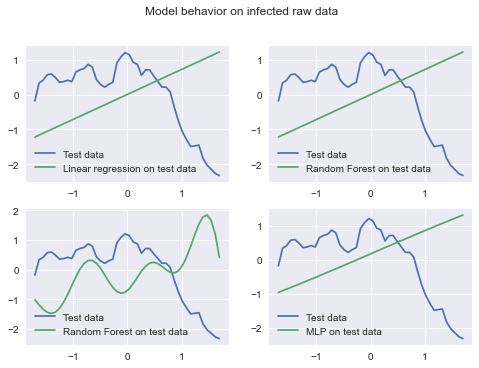

In [373]:
fig, axs = plt.subplots(2, 2)
fig.suptitle('Model behavior on infected raw data')


# Linear regression
lin_reg = LinearRegression(n_jobs=1)
lin_reg.fit(transformed_dead_X_train, transformed_dead_y_train)

predictions = lin_reg.predict(transformed_dead_X_test)
lin_mse = mean_squared_error(transformed_dead_y_test, predictions)
lin_rmse = np.sqrt(lin_mse)

# Random forest
forest_reg = RandomForestRegressor(max_depth=4, n_estimators=500)
forest_reg.fit(transformed_dead_X_train, transformed_dead_y_train)
forest_predictions = forest_reg.predict(transformed_dead_X_test)

forest_mse = mean_squared_error(transformed_dead_y_test, forest_predictions)
forest_rmse = np.sqrt(forest_mse)

# SVR
svr = SVR(C=50, degree=1, epsilon=0.3)
svr.fit(transformed_dead_X_train, transformed_dead_y_train)
svr_preds = svr.predict(transformed_dead_X_test)
svr_mse = mean_squared_error(transformed_dead_y_test, svr_preds)
svr_rmse = np.sqrt(svr_mse)

# MLP
mlp = MLPRegressor(
    activation='logistic',
    learning_rate_init=0.01,
    random_state=1, max_iter=200).fit(transformed_dead_X_train, transformed_dead_y_train)
mlp_preds = mlp.predict(transformed_dead_X_test)
mlp_mse = mean_squared_error(transformed_dead_y_test, mlp_preds)
mlp_rmse = np.sqrt(mlp_mse)


# Plots
# sns.lineplot(x=transformed_dead_X_train.reshape(-1), y=transformed_dead_y_trainreshape(-1), label='Train data', ax=axs[0,0])
sns.lineplot(x=transformed_dead_X_test.reshape(-1), y=transformed_dead_y_test.reshape(-1), label='Test data', ax=axs[0,0])
# sns.lineplot(x=transformed_dead_X_train.reshape(-1), y=lin_reg.predict(transformed_dead_X_train)reshape(-1), label='Linear regression on train data', ax=axs[0,0])
sns.lineplot(x=transformed_dead_X_test.reshape(-1), y=predictions.reshape(-1), label='Linear regression on test data', ax=axs[0,0])

# sns.lineplot(x=transformed_dead_X_train.reshape(-1), y=transformed_dead_y_trainreshape(-1), label='Train data', ax=axs[0,1])
sns.lineplot(x=transformed_dead_X_test.reshape(-1), y=transformed_dead_y_test.reshape(-1), label='Test data', ax=axs[0,1])
# sns.lineplot(x=transformed_dead_X_train.reshape(-1), y=transformed_dead_reg.predict(transformed_infected_X_train)reshape(-1), label='Random Forest on train data', ax=axs[0,1])
sns.lineplot(x=transformed_dead_X_test.reshape(-1), y=predictions.reshape(-1), label='Random Forest on test data', ax=axs[0,1])

# sns.lineplot(x=transformed_dead_X_train, y=transformed_dead_y_train, label='Train data', ax=axs[1,0])
sns.lineplot(x=transformed_dead_X_test.reshape(-1), y=transformed_dead_y_test.reshape(-1), label='Test data', ax=axs[1,0])
# sns.lineplot(x=transformed_dead_X_train, y=svr.predict(transformed_dead_X_train), label='Random Forest on train data', ax=axs[1,0])
sns.lineplot(x=transformed_dead_X_test.reshape(-1), y=svr_preds.reshape(-1), label='Random Forest on test data', ax=axs[1,0])

# sns.lineplot(x=transformed_dead_X_train, y=transformed_dead_y_train, label='Train data', ax=axs[1,1])
sns.lineplot(x=transformed_dead_X_test.reshape(-1), y=transformed_dead_y_test.reshape(-1), label='Test data', ax=axs[1,1])
# sns.lineplot(x=transformed_dead_X_train, y=mlp.predict(transformed_dead_X_train), label='MLP on train data', ax=axs[1,1])
sns.lineplot(x=transformed_dead_X_test.reshape(-1), y=mlp_preds.reshape(-1), label='MLP on test data', ax=axs[1,1])


Gráfico 7: Ajuste dos modelos na contagem de infectados após normalização e ajuste dos parâmetros

In [374]:
print('###'*9)
print('Linear regression Scores')
print('---'*9)
print('Score: ', lin_reg.score(transformed_dead_X_test.reshape(-1, 1), transformed_dead_y_test))
print('R-2: ', metrics.r2_score(transformed_dead_y_test, predictions))
print('Absolute Error: ', metrics.mean_absolute_error(transformed_dead_y_test, predictions))
print('RMSE: ', lin_rmse)

print('###'*9)
print('Random forest Scores')
print('---'*9)
print('Score: ', forest_reg.score(transformed_dead_X_test.reshape(-1, 1), transformed_dead_y_test))
print('R-2: ', metrics.r2_score(transformed_dead_y_test, forest_predictions))
print('Absolute Error: ',metrics.mean_absolute_error(transformed_dead_y_test, forest_predictions))
print('RMSE: ', forest_rmse)

print('###'*9)
print('SVR')
print('---'*9)
print('Score: ', svr.score(transformed_dead_X_test, transformed_dead_y_test))
print('R-2: ', metrics.r2_score(transformed_dead_y_test, svr_preds))
print('Absolute Error: ',metrics.mean_absolute_error(transformed_y_test, svr_preds))
print('RMSE: ', svr_rmse)

print('###'*9)
print('MLP')
print('---'*9)
print('Score: ', mlp.score(transformed_X_test.reshape(-1, 1), transformed_y_test))
print('R-2: ', metrics.r2_score(transformed_y_test, mlp_preds))
print('Absolute Error: ', metrics.mean_absolute_error(transformed_y_test, mlp_preds))
print('RMSE: ', mlp_rmse)
print('---'*9)

###########################
Linear regression Scores
---------------------------
Score:  -1.5352202201569396
R-2:  -1.5352202201569396
Absolute Error:  1.3332783833747899
RMSE:  1.5922374886168644
###########################
Random forest Scores
---------------------------
Score:  -2.1482252146450995
R-2:  -2.1482252146450995
Absolute Error:  1.3538487641033263
RMSE:  1.7743238753522705
###########################
SVR
---------------------------
Score:  -1.9250406101215343
R-2:  -1.9250406101215343
Absolute Error:  1.3634615321297847
RMSE:  1.710275010085084
###########################
MLP
---------------------------
Score:  -1.4472046007046875
R-2:  -1.4472046007046875
Absolute Error:  1.2505145846339207
RMSE:  1.5643543718431216
---------------------------


### Conclusão

<p style="text-align:justify;">
Pode-se notar que após aplicar a normalização dos dados através de um <i>imputer</i> e um <i>StandardScaling</i> e escolher uma melhor combinação de parâmetros para os modelos de teste, pode-se obter resultados melhores, minimzando a taxa de erros e maximizando a pontuação do modelo. Mesmo que os resultados das previsões ainda sejam insatisfatorios, é inquestionável que a aplicação da normalização minimiza moderadamente a taxa de erros. A regressão inicial aplicada aos de infectados dados não escalonados apresentou pontuação de -21% e após da normalização chegou a 80%. A Floresta aleatória atingiu 62% de pontuação após a normalização. Todos os modelos apresentaram redução na taxa de erros. Convém-se, como conclussão deste estudo, que a normalização dos dados e escolha dos parâmetros são uma etapa fundamental na fase de pré-processamebnto dos dados, podendo impactar fortemente no resultado final.
</p>

## Referências

<hr />
<br />

CURITIBA, Prefeitura Municipal de. **Endereços da Vigilância Sanitária Municipal**. 2021. Online, disponível em: https://www.curitiba.pr.gov.br/servicos/enderecos-da-vigilancia-sanitaria-municipal/729 Acesso em: 21/07/2021;

GÉRON, Aurélien. Mãos à Obra Aprendizado de máquina com Scikit-Learn & tensorFlow: Conceitos, Ferramentas e técnicas para a construção de Sistemas Inteligentes. Rio de Janeiro:  Alta Books, 2019;

GUIZELINI, Dieval et al. Algoritmos Genéticos e média móvel para ajuste da curva de predição da infecção por SARS-Cov-2. In: Algoritmos Genéticos e média móvel para ajuste da curva de predição da infecção por SARS-Cov-2. [S. l.], 2020. Disponível em: https://www.bioinfo.ufpr.br/covid19/index.html. Acesso em: 22 jul. 2021.

HARRISON, Matt. Machine Learning: Guia de Referência Rápida. Novatec, 1˚ edição. 2020;

JAIN, Akshay P. Time Series Forecasting – Data, Analysis, and Practice. Neptune ai, 2021. Online, Disponível em: https://neptune.ai/blog/time-series-forecasting. Acesso em: 22 jul. 2021.

OLIVEIRA, Alcides Augusto Souto de. **Casos de COVID-19 em Curitiba**. Prefeitura de Curitiba - Dados abertos, 2021; Online: Disponível em: <https://www.curitiba.pr.gov.br/dadosabertos/busca/?pagina=2> Último acesso em: 21/07/2021;

RIZZATTI, Maurício et al. MAPEAMENTO DA COVID-19 POR MEIO DA DENSIDADE DE KERNEL. Metodologias e Aprendizado, [S. l.], v. 3, p. 44-53, 24 maio 2020. DOI https://doi/10.21166/metapre.v3i0.1312. Disponível em: https://publicacoes.ifc.edu.br/index.php/metapre/article/view/1312/1020. Acesso em: 22 jul. 2021.

